# Load & plot sea ice concentration in the Beaufort Sea for SASSIE

Uses SIC data from NOAA that has been re-gridded to lat/lon coords already

Kyla Drushka, Jan 2022


In [77]:
import sys
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker

import glob
import numpy as np

import cartopy

In [81]:
# use regridded SIC data. 
# see convert_seaice_coords.ipynb for convesersion

# just load data from sept 15:
seaicedir = '/data1/sassie/satellite/seaice/sic_daily_v3/regridded/'
fg = sorted(glob.glob(seaicedir + '**0915**nc'))
print(f'{len(fg)} files')

7 files


In [82]:
# load all files into xarray
ds = xr.open_mfdataset(fg)
# 0-360 => -180-180
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)
ds

<xarray.Dataset>
Dimensions:                         (lat: 601, lon: 3601, time: 7)
Coordinates:
  * time                            (time) datetime64[ns] 2014-09-15 ... 2020...
  * lon                             (lon) float64 -180.0 -179.9 ... 179.8 179.9
  * lat                             (lat) float64 30.0 30.1 30.2 ... 89.9 90.0
Data variables:
    seaice_conc_cdr                 (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    stdev_of_seaice_conc_cdr        (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    melt_onset_day_seaice_conc_cdr  (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    qa_of_seaice_conc_cdr           (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    goddard_merged_seaice_conc      (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    goddard_nt_seaice_conc          (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
    goddard_bt_seaice_conc          (time, lat, lon) float32 dask.array<chunksize=(1, 601, 3601), meta=np.ndarray>
Attributes: (12/43)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    source:                    ftp://sidads.colorado.edu/DATASETS/nsidc0001_p...
    institution:               NSIDC > National Snow and Ice Data Center
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    ...                        ...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2017-11-30T01:10:47Z
    time_coverage_start:       2014-09-15T00:00:00Z
    time_coverage_end:         2014-09-15T23:59:59Z
    comment:                   none
    CDO:                       Climate Data Operators version 1.9.9 (https://...

/home/kdrushka/miniconda3/envs/py33/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


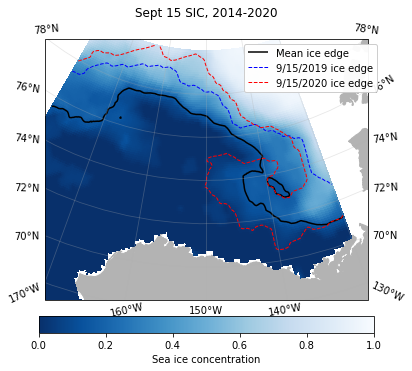

In [84]:
# plot: one panel with mean, 2019 and 2020 contoured
# (sloppy - just select the year index myself)
# lat/lon limits for plot
xrange = slice(-180, -130)
yrange = slice(50, 80)
sic_level = 0.15 # SIC value to contour

fig, ax1 = plt.subplots(1,1, 
                        subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-150)}, 
                        figsize=(6,6))

# mean sic
data = ds.seaice_conc_cdr.sel(lon=xrange, lat=yrange).mean(dim='time').data
pc = ax1.pcolormesh(ds.lon.sel(lon=xrange).data, ds.sel(lat=yrange).lat.data,data,
                   transform=ccrs.PlateCarree(),
                   vmin = 0,
                   vmax = 1,
                   cmap = 'Blues_r')

# add a contour of mean SIC
cmean = ax1.contour(ds.lon.sel(lon=xrange).data, ds.sel(lat=yrange).lat.data,data,
                    levels=[sic_level],
                    colors='k',
                    transform=ccrs.PlateCarree())
# add a contour of 2019 SIC
data = ds.seaice_conc_cdr.isel(time=5).sel(lon=xrange, lat=yrange).data
c19 = ax1.contour(ds.lon.sel(lon=xrange).data, ds.sel(lat=yrange).lat.data,data,
                    levels=[sic_level],
                    colors='b',
                    linewidths=1,
                    linestyles='dashed',
                    transform=ccrs.PlateCarree())
# add a contour of 2020 SIC
data = ds.seaice_conc_cdr.isel(time=6).sel(lon=xrange, lat=yrange).data
c20 = ax1.contour(ds.lon.sel(lon=xrange).data, ds.sel(lat=yrange).lat.data,data,
                    levels=[sic_level],
                    colors='r',
                    linestyles='dashed',
                    linewidths=1,
                    transform=ccrs.PlateCarree())

#  ----- map stuff
ax1.coastlines(color='none')  # coastline
ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
ax1.set_title('Sept 15 SIC, 2014-2020')
plt.colorbar(pc, ax=ax1, orientation="horizontal", pad=0.05).set_label("Sea ice concentration")
# land color
ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
# ticks
gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
gl.top_labels = False
gl.bottom_labels = True
# add contours to legend
cmean.collections[0].set_label('Mean ice edge')
c19.collections[0].set_label('9/15/2019 ice edge')
c20.collections[0].set_label('9/15/2020 ice edge')
plt.legend(bbox_to_anchor=(.6,1),loc='upper left', framealpha=0.95)  

# save:
plt.savefig('/data2/Dropbox/projects/sassie_kd/docs/SIC.png', dpi=400, transparent=False, facecolor='white')